In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_func = np.linspace(-4,4,100)
y_func = x_func

x_train = np.random.uniform(-3, -2, 50)
y_train = x_train + np.random.randn(*x_train.shape)*0.5

x_train = np.concatenate([x_train, np.random.uniform(2, 3, 50)])
y_train = np.concatenate([y_train, x_train[50:] + np.random.randn(*x_train[50:].shape)*0.1])
x_test = np.linspace(-10,10,100)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, label='training data')
ax.plot(x_func, y_func, ls='--', label='real function', color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data with uncertainty')
plt.show()

<Figure size 1000x500 with 1 Axes>

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6     

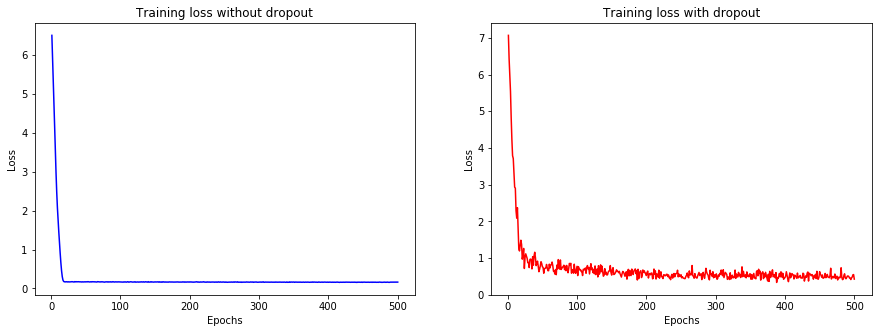

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2

def architecture(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu', verbose=False):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
          hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
      hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(output_dim, kernel_regularizer=l2(reg))(hidden)
    model = Model(inputs, outputs)
    if verbose:
      model.summary()
    return model

model_without_dropout = architecture(layers_shape=[5,10,20,10,5], input_dim= 1, output_dim=1,
                                     dropout_proba=0, reg=0, act='relu', verbose=1)

model_with_dropout = architecture(layers_shape=[5,10,20,10,5], input_dim= 1, output_dim=1,
                                  dropout_proba=0.05, reg=0.00475, act='relu', verbose=1)
model_without_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
print("go!")
history_without_dropout = model_without_dropout.fit(x_train, y_train, batch_size=10,
                                                    epochs=500, shuffle=True, verbose=0)

# training the network with dropout
model_with_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_with_dropout = model_with_dropout.fit(x_train, y_train, batch_size=10,
                                              epochs=500, shuffle=True, verbose=0)

# training performance
epochs = range(1, len(history_without_dropout.history['loss']) + 1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(epochs, history_without_dropout.history['loss'], 'b')
ax[0].set_title('Training loss without dropout')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].plot(epochs, history_with_dropout.history['loss'], 'r')
ax[1].set_title('Training loss with dropout')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss');
plt.show()

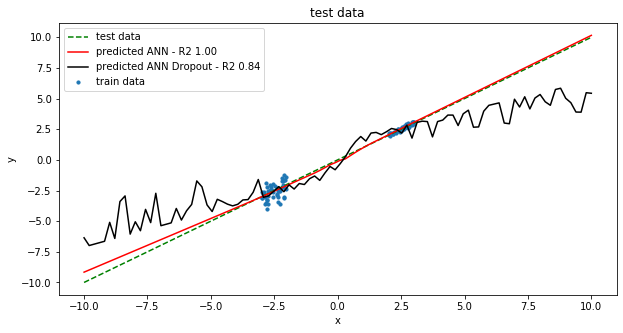

In [5]:
from sklearn.metrics import r2_score
# prediction
y_pred_without_dropout = model_without_dropout.predict(x_test)
y_pred_with_dropout = model_with_dropout.predict(x_test)

# plotting
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, s=10, label='train data')
ax.plot(x_test, x_test, ls='--', label='test data', color='green')
ax.plot(x_test, y_pred_without_dropout, label='predicted ANN - R2 {:.2f}'.format(r2_score(x_test, y_pred_without_dropout)), color='red')
ax.plot(x_test, y_pred_with_dropout, label='predicted ANN Dropout - R2 {:.2f}'.format(r2_score(x_test, y_pred_with_dropout)), color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('test data');


/home/mephody_bro/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
/home/mephody_bro/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


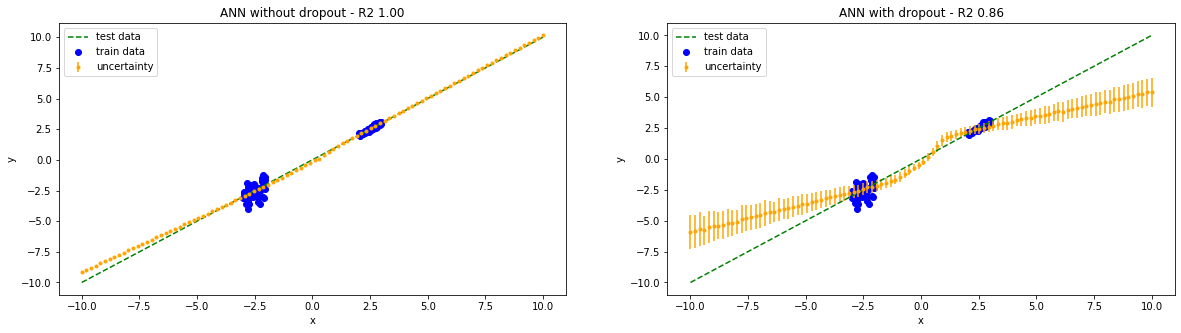

In [6]:

def plot_epistemic_uncertainty(model, ax, title,
                     x_train=x_train, y_train=y_train,
                     x_test=np.linspace(-10,10,100), y_test=np.linspace(-10,10,100),
                     T=500):
  predictions = []
  for _ in range(T):
      predictions += [model.predict(x_test,verbose=0)]
  mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
  ax.plot(x_test, y_test, ls='--', color='green', label='test data')
  ax.scatter(x_train, y_train, color='blue', label='train data')
  ax.errorbar(x_test, mean, yerr=std, fmt='.', color='orange', label='uncertainty')
  ax.set_title('{} - R2 {:.2f}'.format(title, r2_score(y_test, mean)))
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.legend();

fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_epistemic_uncertainty(model_without_dropout, ax=ax[0], title='ANN without dropout')
plot_epistemic_uncertainty(model_with_dropout, ax=ax[1], title='ANN with dropout')